<a href="https://colab.research.google.com/github/amruthavinayakam/Langgraph_Chatbots/blob/main/Langgraph_Chatbot_With_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [2]:
#manages state
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

In [4]:
# working with tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#Arxiv and Wikipedia tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke(" summarise who is Shah Rukh Khan")

'Page: Kal Ho Naa Ho\nSummary: Kal Ho Naa Ho (transl.\u2009Tomorrow may never come, pronounced [kəl ɦoː naː ɦoː]), also abbreviated as KHNH, is a 2003 Indian Hindi-language romantic comedy drama film directed by debutant Nikhil Advani from a script written by Karan Johar and Niranjan Iyengar, and produced '

In [6]:
arxiv_tool.invoke(" summarise Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [7]:
tools=[wiki_tool] # We can add any number of tools

In [8]:
#Langgraph Application

from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [9]:
from langgraph.graph import StateGraph, START, END

In [10]:
graph_builder=StateGraph(State)

In [11]:
from langchain_groq import ChatGroq

In [12]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

In [17]:
llm=ChatGroq(groq_api_key=GROQ_API_KEY, model='Gemma2-9b-It')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7cd138f14690>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7cd13b0779d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [20]:
llm_with_tools=llm.bind_tools(tools=tools)

In [21]:
def chatbot(state:State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [22]:
from langgraph.prebuilt import ToolNode, tools_condition

In [23]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)



In [24]:
graph=graph_builder.compile()

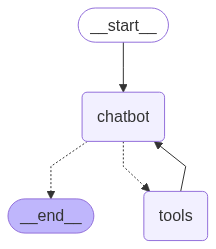

In [25]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [28]:
user_input="Hello! My name is Shahrukh"

events=graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello! My name is Shahrukh
================================== Ai Message ==================================
Tool Calls:
  wikipedia (vm0zgyaqc)
 Call ID: vm0zgyaqc
  Args:
    query: Shahrukh Khan
================================= Tool Message =================================
Name: wikipedia

Page: Shah Rukh Khan
Summary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10
================================== Ai Message ==================================
Tool Calls:
  wikipedia (0sgeqrtch)
 Call ID: 0sgeqrtch
  Args:
    query: Bollywood
================================= Tool Message =================================
Name: wikipedia

Page: Hindi cinema
Summary: Hindi cinema, popularly known 